In [1]:
# %%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
# rm -rf 6864-hw1
# git clone https://github.com/lingo-mit/6864-hw1.git

In [2]:
# import sys
# sys.path.append("/content/6864-hw1")

import csv
import itertools as it
import numpy as np
np.random.seed(0)

import lab_util

In [3]:
from matplotlib import pyplot as plt

## Introduction

In this lab, you'll explore three different ways of using unlabeled text data to learn pretrained word representations. Your lab report will describe the effects of different modeling decisions (representation learning objective, context size, etc.) on both qualitative properties of learned representations and their effect on a downstream prediction problem.

**General lab report guidelines**

Homework assignments should be submitted in the form of a research report. (We'll be providing a place to upload them before the due date, but are still sorting out some logistics.) Please upload PDFs, with a maximum of four single-spaced pages. (If you want you can use the [Association for Computational Linguistics style files](http://acl2020.org/downloads/acl2020-templates.zip).) Reports should have one section for each part of the homework assignment below. Each section should describe the details of your code implementation, and include whatever charts / tables are necessary to answer the set of questions at the end of the corresponding homework part.



We're going to be working with a dataset of product reviews. It looks like this:

In [4]:
data = []
n_positive = 0
n_disp = 0
# with open("/content/6864-hw1/reviews.csv") as reader:
with open("reviews.csv") as reader:
    csvreader = csv.reader(reader)
    next(csvreader)
    for id, review, label in csvreader:
        label = int(label)

        # hacky class balancing
        if label == 1:
            if n_positive == 2000:
                continue
            n_positive += 1
        if len(data) == 4000:
            break

        data.append((review, label))
    
        if n_disp > 5:
            continue
        n_disp += 1
        print("review:", review)
        print("rating:", label, "(good)" if label == 1 else "(bad)")
        print()

print(f"Read {len(data)} total reviews.")
np.random.shuffle(data)
reviews, labels = zip(*data)
train_reviews = reviews[:3000]
train_labels = labels[:3000]
val_reviews = reviews[3000:3500]
val_labels = labels[3000:3500]
test_reviews = reviews[3500:]
test_labels = labels[3500:]

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

We've provided a little bit of helper code for reading in the dataset; your job is to implement the learning!

## Part 1: word representations via matrix factorization

First, we'll construct the term--document matrix (look at `/content/6864-hw1/lab_util.py` in the file browser on the left if you want to see how this works).

In [5]:
vectorizer = lab_util.CountVectorizer()
vectorizer.fit(train_reviews)
td_matrix = vectorizer.transform(train_reviews).T
print(f"TD matrix is {td_matrix.shape[0]} x {td_matrix.shape[1]}")

TD matrix is 2006 x 3000


First, implement a function that computes word representations via latent semantic analysis:

In [6]:
from numpy.linalg import svd

def learn_reps_lsa(matrix, rep_size):
    # `matrix` is a `|V| x n` matrix, where `|V|` is the number of words in the
    # vocabulary. This function should return a `|V| x rep_size` matrix with each
    # row corresponding to a word representation. The `sklearn.decomposition` 
    # package may be useful.

    u, _, _ = svd(matrix)
    return u[:, :rep_size]

# from sklearn.decomposition import TruncatedSVD

# def learn_reps_lsa_alt(matrix, rep_size):
#     # One issue is that TruncatedSVD returns the truncation of U*Sigma, not U
#     svd = TruncatedSVD(n_components=rep_size)
#     svd.fit(matrix.T)
#     return svd.components_.T

Let's look at some representations:

In [7]:
reps = learn_reps_lsa(td_matrix, 500)
words = ["good", "bad", "cookie", "jelly", "dog", "the", "4"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]
lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

good 47
  gerber 1.873
  luck 1.885
  crazy 1.890
  flaxseed 1.906
  suspect 1.907
bad 201
  disgusting 1.625
  horrible 1.776
  shortbread 1.778
  gone 1.778
  dont 1.802
cookie 504
  nana's 0.964
  bars 1.363
  odd 1.402
  impossible 1.459
  cookies 1.484
jelly 351
  twist 1.099
  cardboard 1.197
  peanuts 1.311
  advertised 1.331
  plastic 1.510
dog 925
  happier 1.670
  earlier 1.681
  eats 1.702
  stays 1.722
  standard 1.727
the 36
  suspect 1.953
  flowers 1.961
  leaked 1.966
  m 1.966
  burn 1.967
4 292
  shortbread 1.674
  toast 1.683
  mistake 1.690
  2nd 1.701
  icing 1.723


We've been operating on the raw count matrix, but in class we discussed several reweighting schemes aimed at making LSA representations more informative. 

Here, implement the TF-IDF transform and see how it affects learned representations.

In [8]:
def transform_tfidf(matrix):
    # `matrix` is a `|V| x |D|` matrix of raw counts, where `|V|` is the 
    # vocabulary size and `|D|` is the number of documents in the corpus. This
    # function should (nondestructively) return a version of `matrix` with the
    # TF-IDF transform appliied.

    num_docs = matrix.shape[1]
    tf_matrix = matrix.copy()
    td_occurrence = np.sum(np.where(tf_matrix > 0, 1, 0), axis=1, keepdims=True)
    idf = np.log(num_docs / td_occurrence)
    return tf_matrix * idf

How does this change the learned similarity function?

In [9]:
td_matrix_tfidf = transform_tfidf(td_matrix)
reps_tfidf = learn_reps_lsa(td_matrix_tfidf, 500)
lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)

good 47
  crazy 1.695
  gerber 1.753
  beat 1.758
  homemade 1.785
  tasting 1.799
bad 201
  disgusting 1.623
  awful 1.713
  positive 1.715
  bland 1.731
  gone 1.736
cookie 504
  nana's 1.103
  moist 1.388
  odd 1.452
  impossible 1.486
  needs 1.509
jelly 351
  twist 1.156
  cardboard 1.211
  advertised 1.402
  plum 1.447
  sold 1.470
dog 925
  happier 1.641
  earlier 1.658
  foods 1.690
  stays 1.697
  eats 1.704
the 36
  <unk> 1.478
  and 1.578
  . 1.581
  of 1.627
  is 1.632
4 292
  mistake 1.687
  2nd 1.707
  toast 1.708
  table 1.714
  70 1.723


Now that we have some representations, let's see if we can do something useful with them.

Below, implement a feature function that represents a document as the sum of its
learned word embeddings.

The remaining code trains a logistic regression model on a set of *labeled* reviews; we're interested in seeing how much representations learned from *unlabeled* reviews improve classification.

In [9]:
print(reps_tfidf.shape)
reps_tfidf

(2006, 500)


array([[-0.10305843, -0.02823013, -0.0005387 , ..., -0.01696821,
         0.01761233, -0.02429318],
       [-0.06121867, -0.00787906, -0.13199975, ..., -0.01126481,
        -0.02398841, -0.01012468],
       [-0.07905045, -0.00272372, -0.09267989, ...,  0.03373111,
         0.01590188, -0.00704764],
       ...,
       [-0.00502214,  0.00256818,  0.00766008, ...,  0.01296829,
         0.01490828,  0.01262186],
       [-0.00553081, -0.00273609, -0.00441299, ..., -0.00932143,
        -0.02297195, -0.00735671],
       [-0.02840451, -0.09642188,  0.00128551, ..., -0.01933431,
        -0.00171207,  0.00382342]])

In [42]:
def word_featurizer(xs):
    # normalize
    return xs / np.sqrt((xs ** 2).sum(axis=1, keepdims=True))

def lsa_featurizer(xs):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the learned feature representation of each review (e.g. the sum of LSA 
    # word representations).

    feats = xs@reps_tfidf

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

def combo_featurizer(xs):
    return np.concatenate((word_featurizer(xs), lsa_featurizer(xs)), axis=1)

def train_model(featurizer, xs, ys):
    import sklearn.linear_model
    xs_featurized = featurizer(xs)
    model = sklearn.linear_model.LogisticRegression()
    model.fit(xs_featurized, ys)
    return model

def eval_model(model, featurizer, xs, ys, verbose=True):
    xs_featurized = featurizer(xs)
    pred_ys = model.predict(xs_featurized)
    acc = np.mean(pred_ys == ys)
    if verbose: print("test accuracy", acc)
    return acc

def training_experiment(name, featurizer, n_train, verbose=True):
    if verbose: print(f"{name} features, {n_train} examples")
    train_xs = vectorizer.transform(train_reviews[:n_train])
    train_ys = train_labels[:n_train]
    test_xs = vectorizer.transform(test_reviews)
    test_ys = test_labels
    model = train_model(featurizer, train_xs, train_ys)
    acc = eval_model(model, featurizer, test_xs, test_ys, verbose=verbose)
    if verbose: print()
    return acc

training_experiment("word", word_featurizer, 10)
training_experiment("lsa", lsa_featurizer, 10)
training_experiment("combo", combo_featurizer, 10)
print()

word features, 10 examples
test accuracy 0.496

lsa features, 10 examples
test accuracy 0.484

combo features, 10 examples
test accuracy 0.484




**Part 1: Lab writeup**

Part 1 of your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Qualitatively, what do you observe about nearest neighbors in representation    space? (E.g. what words are most similar to _the_, _dog_, _3_, and _good_?)

2. How does the size of the LSA representation affect this behavior?


3. Recall that the we can compute the word co-occurrence matrix $W_{tt} = W_    
   {td} W_{td}^\top$. What can you prove about the relationship between the    
   left singular vectors of $W_{td}$ and $W_{tt}$? Do you observe this behavior 
   with your implementation of `learn_reps_lsa`? Why or why not?

4. Do learned representations help with the review classification problem? What
   is the relationship between the number of labeled examples and the effect of
   word embeddings?
   
5. What is the relationship between the size of the word embeddings and their      usefulness for the classification task.

In [46]:
train_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

word_500_results = []
lsa_500_results = []
combo_500_results = []

reps_tfidf = learn_reps_lsa(td_matrix_tfidf, 500)

for n in train_sizes:
    word_500_results.append(training_experiment("word", word_featurizer, n, verbose=False))
    lsa_500_results.append(training_experiment("lsa", lsa_featurizer, n, verbose=False))
    combo_500_results.append(training_experiment("combo", combo_featurizer, n, verbose=False))

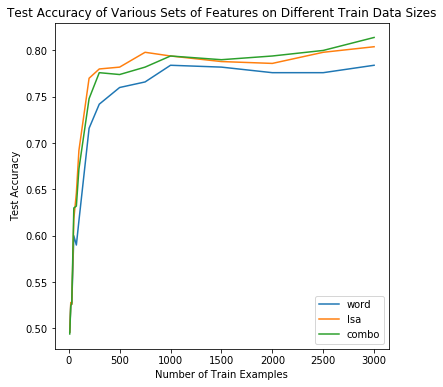

In [47]:
plt.figure(figsize=(6, 6))
plt.plot(train_sizes, word_500_results, label="word")
plt.plot(train_sizes, lsa_500_results, label="lsa")
plt.plot(train_sizes, combo_500_results, label="combo")
plt.legend(loc = "lower right")
plt.title('Test Accuracy of Various Sets of Features on Different Train Data Sizes')
plt.xlabel('Number of Train Examples')
plt.ylabel('Test Accuracy')

plt.savefig('assets/word_embed_matrix_e500.png')
plt.show()

In [48]:
embedding_sizes = [10, 50, 100, 500, 1000, 2006]
for embed_sz in embedding_sizes:
    print("Embedding size: ", embed_sz)
    reps_tfidf = learn_reps_lsa(td_matrix_tfidf, embed_sz)
    lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)
    print()

Embedding size:  10
good 47
  very 0.207
  . 0.210
  p 0.227
  sure 0.235
  u 0.260
bad 201
  agree 0.240
  entirely 0.274
  positive 0.274
  forward 0.282
  overly 0.285
cookie 504
  cookies 0.204
  muffins 0.261
  cake 0.262
  tough 0.271
  excellent 0.274
jelly 351
  gifts 0.091
  soups 0.098
  vanilla 0.112
  mixing 0.121
  stuck 0.134
dog 925
  dogs 0.119
  him 0.137
  baby 0.147
  he 0.191
  lamb 0.194
the 36
  have 0.086
  in 0.103
  . 0.122
  be 0.140
  that 0.145
4 292
  1 0.039
  6 0.069
  5 0.112
  protein 0.114
  7 0.124

Embedding size:  50
good 47
  quick 0.594
  everyone 0.673
  decide 0.674
  than 0.713
  better 0.726
bad 201
  expect 0.787
  feeling 0.853
  strange 0.875
  just 0.936
  about 0.943
cookie 504
  cookies 0.282
  nana's 0.325
  oreos 0.634
  bars 0.708
  shortbread 0.818
jelly 351
  gifts 0.432
  creamer 0.603
  online 0.798
  milk 0.838
  maybe 0.864
dog 925
  foods 0.574
  pet 0.636
  nutritious 0.652
  pets 0.687
  switched 0.719
the 36
  of 0.723
  . 0

In [35]:
embedding_sizes = [10, 50, 100, 500, 1000, 2000]
train_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

word_embed_results = {esz: {"word": [], "lsa": [], "combo": []} for esz in embedding_sizes}

for embed_sz in embedding_sizes:
    reps_tfidf = learn_reps_lsa(td_matrix_tfidf, embed_sz)
    
    word_results = word_embed_results[embed_sz]["word"]
    lsa_results = word_embed_results[embed_sz]["lsa"]
    combo_results = word_embed_results[embed_sz]["combo"]

    for n in train_sizes:
        word_results.append(training_experiment("word", word_featurizer, n, verbose=False))
        lsa_results.append(training_experiment("lsa", lsa_featurizer, n, verbose=False))
        combo_results.append(training_experiment("combo", combo_featurizer, n, verbose=False))

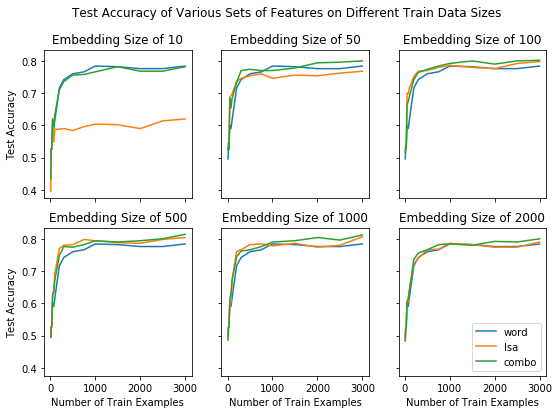

In [36]:
nrow = 2
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,6), sharex = True, sharey=True)
for i, embed_sz in enumerate(embedding_sizes):
    axs[i//ncol, i%ncol].plot(train_sizes, word_embed_results[embed_sz]["word"], label="word")
    axs[i//ncol, i%ncol].plot(train_sizes, word_embed_results[embed_sz]["lsa"], label="lsa")
    axs[i//ncol, i%ncol].plot(train_sizes, word_embed_results[embed_sz]["combo"], label="combo")
    axs[i//ncol, i%ncol].set_title('Embedding Size of {}'.format(embed_sz))

for ax in axs.flat:
    ax.set(xlabel='Number of Train Examples', ylabel='Test Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend(loc = "lower right")
plt.suptitle('Test Accuracy of Various Sets of Features on Different Train Data Sizes')
# plt.subplots_adjust(hspace=0.2)

plt.savefig('assets/word_embed_matrix_embed-ntrain.png')
plt.show()

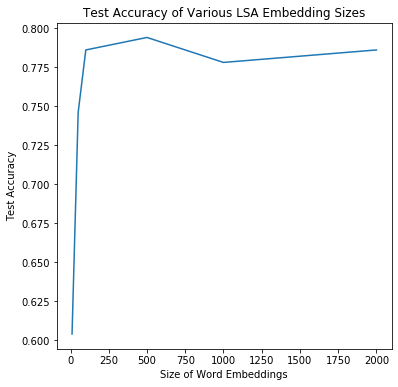

In [37]:
train_size = 1000
train_idx = train_sizes.index(train_size)

lsa_acc_by_embed_size = []
for embed_sz in embedding_sizes:
    acc = word_embed_results[embed_sz]["lsa"][train_idx]
    lsa_acc_by_embed_size.append(acc)

plt.figure(figsize=(6, 6))

plt.plot(embedding_sizes, lsa_acc_by_embed_size, label="lsa")
# plt.legend(loc = "lower right")
plt.title('Test Accuracy of Various LSA Embedding Sizes')
plt.xlabel('Size of Word Embeddings')
plt.ylabel('Test Accuracy')

plt.savefig('assets/word_embed_matrix_ntrain{}.png'.format(train_size))
plt.show()

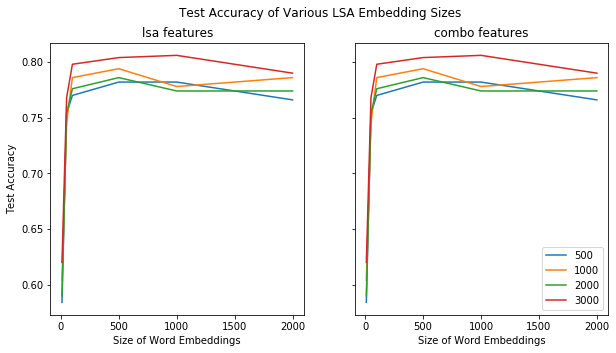

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax_lsa, ax_combo = axs

ax_lsa.set_title('lsa features')
ax_combo.set_title('combo features')

for train_size in [500, 1000, 2000, 3000]:
    train_idx = train_sizes.index(train_size)
    lsa_acc_by_embed_size = []
    combo_acc_by_embed_size = []
    for embed_sz in embedding_sizes:
        acc_lsa = word_embed_results[embed_sz]["lsa"][train_idx]
        lsa_acc_by_embed_size.append(acc_lsa)
        acc_combo = word_embed_results[embed_sz]["combo"][train_idx]
        combo_acc_by_embed_size.append(acc_lsa)
    ax_lsa.plot(embedding_sizes, lsa_acc_by_embed_size, label="{}".format(train_size))
    ax_combo.plot(embedding_sizes, combo_acc_by_embed_size, label="{}".format(train_size))

plt.legend(loc = "lower right")
plt.suptitle('Test Accuracy of Various LSA Embedding Sizes')

for ax in axs.flat:
    ax.set(xlabel='Size of Word Embeddings', ylabel='Test Accuracy')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()

plt.savefig('assets/word_embed_matrix_ntrain.png')
plt.show()

In [43]:
u_td, sigma_td, _ = svd(td_matrix)
u_tt, _, _ = svd(td_matrix@td_matrix.T)
print(u_td)
print(u_tt)
print(sigma_td)

[[ 6.89031937e-01  6.72372892e-01  1.78411037e-01 ...  5.13700980e-05
   4.90437295e-21 -9.44750584e-20]
 [ 2.31553598e-02 -5.20963554e-02 -1.21153239e-02 ... -1.71082540e-05
   4.71371354e-18 -1.05396477e-18]
 [ 3.83301968e-02 -4.29225155e-02 -1.93856196e-02 ...  4.32473026e-04
   1.16146056e-17  6.05555764e-18]
 ...
 [ 3.17231578e-04 -6.50245704e-04 -1.52675912e-03 ...  2.39091962e-03
   2.35042687e-17  1.10276054e-16]
 [ 4.42263586e-04 -2.14287700e-04  4.98282343e-04 ... -1.15934843e-02
   2.79584295e-17 -1.28965953e-16]
 [ 2.76302849e-03  1.39797955e-02  5.86256685e-03 ...  9.53740138e-03
   1.59572510e-16 -8.47125184e-17]]
[[-6.89031937e-01  6.72372892e-01  1.78411037e-01 ...  5.13700980e-05
   8.73918996e-18  5.99157466e-18]
 [-2.31553598e-02 -5.20963554e-02 -1.21153239e-02 ... -1.71082541e-05
   1.42626216e-17 -2.70873106e-17]
 [-3.83301968e-02 -4.29225155e-02 -1.93856196e-02 ...  4.32473026e-04
   5.01336755e-18 -5.45541899e-17]
 ...
 [-3.17231578e-04 -6.50245704e-04 -1.5267591

In [ ]:
print(np.diff(sigma_td) <= 0) # confirm that sigma is indecreasing (non-incr.) order

## Part 2: word representations via language modeling

In this section, we'll train a word embedding model with a word2vec-style objective rather than a matrix factorization objective. This requires a little more work; we've provided scaffolding for a PyTorch model implementation below.
(If you've never used PyTorch before, there are some tutorials [here](https://pytorch.org/tutorials/). You're also welcome to implement these experiments in
any other framework of your choosing.)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

class Word2VecModel(nn.Module):
    # A torch module implementing a word2vec predictor. The `forward` function
    # should take a batch of context word ids as input and predict the word 
    # in the middle of the context as output, as in the CBOW model from lecture.

    def __init__(self, vocab_size, embed_dim):
        super().__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.V = nn.Embedding(vocab_size, embed_dim)
        self.U = nn.Linear(embed_dim, vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, context):
        # Context is an `n_batch x n_context` matrix of integer word ids
        # this function should return a set of scores for predicting the word 
        # in the middle of the context
        n_batch, n_context = context.shape
        embeddings = self.V(context)  # n_batch x n_context x self.embed_dim
        avg_context = torch.sum(embeddings, dim=1)
        output = self.U(avg_context)
        if not self.training:
            # training uses loss that incorporates softmax
            # apply softmax for prediction
            output = self.log_softmax(output)
        return output
        

In [31]:
def learn_reps_word2vec(corpus, window_size, rep_size, n_epochs, n_batch):
    # This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of 
    # the assignment. (You can extract this matrix from the parameters of the 
    # Word2VecModel.)

    tokenizer = lab_util.Tokenizer()
    tokenizer.fit(corpus)
    tokenized_corpus = tokenizer.tokenize(corpus)

    ngrams = lab_util.get_ngrams(tokenized_corpus, window_size)

#     device = torch.device('cuda')  # run on colab gpu
#     device = torch.device('cpu')
#     model = Word2VecModel(tokenizer.vocab_size, rep_size).to(device)
    model = Word2VecModel(tokenizer.vocab_size, rep_size)
    opt = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    model.train()
    for epoch in range(n_epochs):
        for context, label in loader:
            # as described above, `context` is a batch of context word ids (n_batch, n_context), and
            # `label` is a batch of predicted word labels of shape (n_batch,)
#             context = context.to(device)
#             label = label.to(device)

            model.zero_grad()  # clear gradients
            preds = model(context)  # n_batch x vocab_size
            loss = loss_fn(preds, label)
            loss.backward()  # compute gradients
            opt.step()

    # reminder: you want to return a `vocab_size x embedding_size` numpy array
    embedding_matrix = model.V.weight.cpu().detach().numpy()
    return embedding_matrix

In [19]:
# Testing
corpus = train_reviews
window_size = 2
rep_size = 500

ex_context = np.array([
    [1103,   32,  789,  104],
    [ 149,   16,  705,   12],
    [  60,   35,  216,   12],
    [  42,  741,   53,  278],
    [   0, 1822,  480,    3]])
ex_context = torch.LongTensor(ex_context)
ex_label = torch.Tensor([ 21,  19, 872,  12,  74])

tokenizer = lab_util.Tokenizer()
tokenizer.fit(corpus)
tokenized_corpus = tokenizer.tokenize(corpus)

ngrams = lab_util.get_ngrams(tokenized_corpus, window_size)
model = Word2VecModel(tokenizer.vocab_size, rep_size)
print(type(ex_context))
result = model(ex_context)
result.size()

<class 'torch.Tensor'>
tensor([[ 0.5595, -4.5503, -2.0279,  ..., -0.0096,  1.6270, -0.2649],
        [-2.4358,  3.1279, -0.7530,  ...,  1.7882,  0.9369,  4.8111],
        [ 2.0083,  3.8316, -5.3747,  ...,  0.7893, -2.2889, -0.1213],
        [ 4.2201, -3.8971, -2.0721,  ..., -3.4914, -1.5532, -0.5834],
        [-0.1386, -2.4155,  3.1930,  ..., -0.2772,  2.6812, -0.0492]],
       grad_fn=<SumBackward1>)


torch.Size([5, 2006])

In [32]:
reps_word2vec = learn_reps_word2vec(train_reviews, 2, 500, 10, 100)

After training the embeddings, we can try to visualize the embedding space to see if it makes sense. First, we can take any word in the space and check its closest neighbors.

In [33]:
lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)

good 47
  truffles 1.690
  140 1.704
  current 1.709
  impressed 1.725
  poor 1.725
bad 201
  overpowering 1.643
  weird 1.662
  guy 1.702
  complaints 1.718
  crispy 1.725
cookie 504
  jars 1.667
  href 1.702
  supermarket 1.719
  gallon 1.732
  fairly 1.736
jelly 351
  spring 1.700
  daily 1.710
  going 1.715
  packets 1.731
  10 1.733
dog 925
  stick 1.684
  dishes 1.694
  old 1.729
  science 1.737
  brewer 1.748
the 36
  a 1.535
  my 1.609
  mrs 1.632
  another 1.694
  their 1.697
4 292
  carries 1.676
  switch 1.680
  variety 1.706
  number 1.729
  following 1.731


We can also cluster the embedding space. Clustering in 4 or more dimensions is hard to visualize, and even clustering in 2 or 3 can be difficult because there are so many words in the vocabulary. One thing we can try to do is assign cluster labels and qualitiatively look for an underlying pattern in the clusters.

In [34]:
from sklearn.cluster import KMeans

indices = KMeans(n_clusters=10).fit_predict(reps_word2vec)
zipped = list(zip(range(vectorizer.tokenizer.vocab_size), indices))
np.random.shuffle(zipped)
zipped = zipped[:100]
zipped = sorted(zipped, key=lambda x: x[1])
for token, cluster_idx in zipped:
    word = vectorizer.tokenizer.token_to_word[token]
    print(f"{word}: {cluster_idx}")

pieces: 1
eaten: 1
beer: 1
lays: 1
ok: 1
go: 1
has: 1
its: 1
mean: 1
puppy: 1
zero: 1
fiber: 1
rate: 1
colors: 1
packing: 1
holes: 1
rica: 1
than: 2
filled: 2
expiration: 2
him: 2
target: 2
buying: 3
below: 3
cubes: 3
help: 3
update: 3
nearly: 3
needed: 3
learned: 3
will: 3
doesn't: 3
decide: 3
lasts: 3
caramels: 4
large: 4
change: 4
average: 4
potassium: 4
solid: 4
we: 4
fall: 5
spread: 5
lunches: 5
excellent: 5
worked: 5
someone: 5
artificial: 5
plus: 5
shipment: 5
beef: 5
granted: 5
starbucks: 5
im: 6
prime: 6
general: 6
without: 6
crackers: 6
cookies: 6
kind: 6
coffee: 6
never: 6
calcium: 6
morning: 6
description: 6
pouch: 6
still: 6
fruit: 6
truly: 6
next: 6
muffin: 7
brewer: 7
months: 7
subtle: 7
classic: 7
birthday: 7
plum: 7
unfortunately: 7
that's: 7
moved: 8
seen: 8
suggest: 8
given: 8
bought: 8
teeth: 9
amazing: 9
hint: 9
reviews: 9
caffeine: 9
bad: 9
disappointed: 9
times: 9
living: 9
40: 9
un: 9
treats: 9
something: 9
mill: 9
double: 9


Finally, we can use the trained word embeddings to construct vector representations of full reviews. One common approach is to simply average all the word embeddings in the review to create an overall embedding. Implement the transform function in Word2VecFeaturizer to do this.

In [43]:
def word2vec_lsa_featurizer(xs):
    feats = xs@reps_word2vec # Your code here!

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

training_experiment("word2vec", word2vec_lsa_featurizer, 10)

word2vec features, 10 examples
test accuracy 0.522



0.522

**Part 2: Lab writeup**

Part 2 of your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Qualitatively, what do you observe about nearest neighbors in representation space? (E.g. what words are most similar to _the_, _dog_, _3_, and _good_?) How well do word2vec representations correspond to your intuitions about word similarity?

2. One important parameter in word2vec-style models is context size. How does changing the context size affect the kinds of representations that are learned?

3. How do results on the downstream classification problem compare to 
   part 1?

4. What are some advantages and disadvantages of learned embedding representations, relative to the featurization done in part 1?

5. What are some potential problems with constructing a representation of the review by averaging the embeddings of the individual words?

***Do this part in Colab for faster learning in learn_reps_word2vec***

In [ ]:
context_sizes = [1, 2, 3, 5, 10, 20, 30, 50]
for csz in context_sizes:
    print("Context window size: ", csz)
    reps_word2vec_test = learn_reps_word2vec(train_reviews, csz, 500, 10, 100)
    lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec_test, show_tokens)
    print()

In [44]:
train_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

word2vec_500_results = []

# reps_word2vec = learn_reps_word2vec(train_reviews, 2, 500, 10, 100)

for n in train_sizes:
    word2vec_500_results.append(training_experiment("word2vec", word2vec_lsa_featurizer, n, verbose=False))

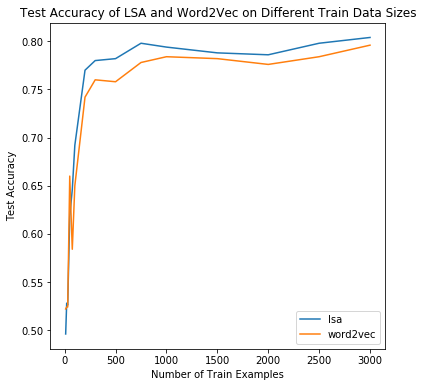

In [48]:
plt.figure(figsize=(6, 6))
plt.plot(train_sizes, lsa_500_results, label="lsa")
plt.plot(train_sizes, word2vec_500_results, label="word2vec")
plt.legend(loc = "lower right")
plt.title('Test Accuracy of LSA and Word2Vec on Different Train Data Sizes')
plt.xlabel('Number of Train Examples')
plt.ylabel('Test Accuracy')

plt.savefig('assets/word2vec-vs-lsa_e500.png')
plt.show()

In [ ]:
embedding_sizes = [10, 50, 100, 500, 1000, 2000]
train_sizes = [10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]

word2vec_results = {esz: [] for esz in embedding_sizes}

for embed_sz in embedding_sizes:
    reps_word2vec = learn_reps_word2vec(train_reviews, 2, embed_sz, 10, 100)

    for n in train_sizes:
        word2vec_results[embed_sz].append(training_experiment("word2vec", word2vec_lsa_featurizer, n, verbose=False))

In [ ]:
nrow = 2
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,6), sharex = True, sharey=True)
for i, embed_sz in enumerate(embedding_sizes):
    axs[i//ncol, i%ncol].plot(train_sizes, word_embed_results[embed_sz]["lsa"], label="lsa")
    axs[i//ncol, i%ncol].plot(train_sizes, word2vec_results[embed_sz], label="word2vec")
    axs[i//ncol, i%ncol].set_title('Embedding Size of {}'.format(embed_sz))

for ax in axs.flat:
    ax.set(xlabel='Number of Train Examples', ylabel='Test Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend(loc = "lower right")
plt.suptitle('Test Accuracy of LSA and Word2Vec on Different Train Data Sizes')
# plt.subplots_adjust(hspace=0.2)

plt.savefig('assets/lsa-word2vec_embed-ntrain.png')
plt.show()